In [ ]:
 %autosave 1

Autosaving every 1 seconds


In [1]:
pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 26.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.5 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11080585 sha256=5027e916c0deb1bff6227e7a9399685d3cb8a992aaed3a3fd6d87fa5c360ad51
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import SubplotSpec
from matplotlib.animation import FuncAnimation
from cartopy import crs, feature
import numpy as np
import glob
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
Path = 'drive/MyDrive/Colab Notebooks/PROFS-WORK/'
#/content/drive/MyDrive/calculated/trans_MPI-M-MPI-ESM-LR_rcp26_GERICS-REMO2015_2031_2060.nc

In [3]:
ds_chirps = xr.open_dataset(Path + 'Ghana_chirps.nc')
ds_rcp85 = xr.open_dataset(Path + 'pr_GHA-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_day_20060101-21001231.nc')
ds_rcp26 = xr.open_dataset(Path + 'pr_GHA-22_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_GERICS-REMO2015_v1_day_20060101-21001231.nc')

mal_data26 = glob.glob(Path+'../../calculated/trans*rcp26*.nc')
mal_data85 = glob.glob(Path+'../../calculated/trans*rcp85*.nc')

mpi =  glob.glob(Path+'../../Mpi/*.nc')

In [4]:
bounds = [-3.5, 1.5, 4.5, 11.5]

In [ ]:
colb = 'rainbow'
vm = 900
vx = 2250
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
def selonlat(ds):
    return(ds.sel(longitude = slice(bounds[0], bounds[1]),
                  latitude = slice(bounds[2], bounds[3])))

def coords(ds):
    ds_ = ds.pr.drop_vars('lon').drop_vars('lat')
    ds_ = ds_.rename({'rlon':'longitude','rlat':'latitude'})
    return(ds_.to_dataset())

def clim_rain(data):
    return data.groupby('time.year').sum('time').mean('year')

def srai(ds):
    tol_sum = ds.groupby('time.year').sum('time').mean('year')
    mon_mean = tol_sum/12
    month = ds.resample(time='1M').sum().groupby('time.month').mean('time')
    return ((abs(month-mon_mean)).sum('month'))/tol_sum

def add_map(ax):
    ax.coastlines()
    ax.add_feature(feature.BORDERS)

def figures(ds1,ds2):
    fig, axes = plt.subplots(ncols = 3, nrows =1, subplot_kw={'projection':crs.PlateCarree()}, constrained_layout=True, figsize=(10,5))
    # fig, axes = plt.subplots(ncols = 3, subplot_kw={'projection':crs.PlateCarree()}, constrained_layout=True)
    chirps = selonlat(ds1.sel(time = slice('1990', '2020'))).precip
    clim_rain(chirps).plot(ax=axes[0], add_colorbar=False, vmax = vx, cmap=colb, vmin=vm)
    title = ['Historical'+ ' 1990-2020','Near Future'+ ' 2031-2060', 'Far Future'+' 2061-2090']
    rcp26 = clim_rain(selonlat(coords(ds2)).sel(time = slice('2031', '2060')).pr*86400)
    rcp26.where(rcp26 <=2500).plot(ax=axes[1], add_colorbar=False, cmap = colb, vmin=vm, vmax=vx)
    rcp85 = clim_rain(selonlat(coords(ds2)).sel(time = slice('2061', '2090')).pr*86400)
    cb = rcp85.where(rcp85 <=2500).plot(ax=axes[2], add_colorbar=False, cmap=colb, vmin=vm, vmax=vx)
    fig.colorbar(cb, ax=axes, shrink=0.5)

    # cax = fig.add_axes([0.95,0.43,0.02, 0.45])
    # fig.colorbar(cb, cax = cax, orientation='vertical')
    for i,j in enumerate(axes):
        axes[i].set_extent(bounds)
        axes[i].set_title(title[i], fontsize = 9)
        axes[i].add_feature(feature.COASTLINE)
        axes[i].add_feature(feature.BORDERS)
        axes[i].add_feature(feature.STATES)
        axes[i].add_feature(feature.BORDERS)
        axes[i].set_xticks([-3,-2.0,-1.0,0,0.8], crs=crs.PlateCarree())
        axes[i].set_yticks([11,10,9,8,7,6,5,4], crs=crs.PlateCarree())
        axes[i].xaxis.set_major_formatter(lon_formatter)
        axes[i].yaxis.set_major_formatter(lat_formatter)
    # plt.suptitle('Rainfall climatology current and future ('+ds2.experiment_id[0:]+')')
    # plt.subplots_adjust(top=1.2)
    # fig.subplots_adjust()
    # fig.tight_layout()


def srai_fig(ds1,ds2):
    fig, axes = plt.subplots(ncols = 3, nrows =1, subplot_kw={'projection':crs.PlateCarree()}, constrained_layout=True, figsize=(10,5))
    chirps = srai(selonlat(ds1.sel(time = slice('1990', '2020'))).precip)
    chirps.plot(ax=axes[0], add_colorbar=False)
    title = ['Historical'+ ' 1990-2020','Near Future'+ ' 2031-2060', 'Far Future'+' 2061-2090']
    rcp26 = selonlat(coords(ds2)).sel(time = slice('2031', '2060')).pr*86400
    srai(rcp26).plot(ax=axes[1], add_colorbar=False)
    # rcp85 = selonlat(coords(ds)).sel(time = slice('2065', '2085')).pr*86400
    # cb = srai(rcp85).plot(ax=axes[2], add_colorbar=False)
    ff = selonlat(coords(ds2)).sel(time = slice('2061', '2090')).pr*86400
    cb = srai(ff).plot(ax=axes[2], add_colorbar=False)
    # cax = fig.add_axes([0.95,0.38,0.02, 0.45])
    fig.colorbar(cb, ax = axes, shrink=0.5)
    for i,j in enumerate(axes):
        axes[i].set_extent(bounds)
        axes[i].set_title(title[i], fontsize = 9)
        axes[i].add_feature(feature.COASTLINE)
        axes[i].add_feature(feature.BORDERS)
        axes[i].add_feature(feature.STATES, linewidth = 0.2)
        axes[i].set_xticks([-3,-2.0,-1.0,0,0.8], crs=crs.PlateCarree())
        axes[i].set_yticks([11,10,9,8,7,6,5,4], crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        axes[i].xaxis.set_major_formatter(lon_formatter)
        axes[i].yaxis.set_major_formatter(lat_formatter)
    # plt.suptitle('Seasonality Index (SI)' + ' ('+ds2.experiment_id[0:]+')')
    # plt.subplots_adjust(top=1.1)
    # plt.tight_layout()

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    row = fig.add_subplot(grid)
    row.set_title(f'{title}\n', fontweight='semibold')#) if row==1 else row.set_title(f'{title}')
    # if row==0 row.set_title(f'{title}\n\n\n', fontweight='semibold') else row.set_title(f'{title}\n'
    row.set_frame_on(False)
    row.axis('off')

def fig_mal(data_26,data_85):
    row =2
    col = 3
    cm='coolwarm'
    vm=12
    vn=6
    fig, axes = plt.subplots(ncols = 3, nrows =2, subplot_kw={'projection':crs.PlateCarree()}, figsize=(10,10))
    # plt.rcParams['figure.constrained_layout.use'] = True
    axes = axes.flatten()

    for i, j in enumerate(data_26):
        if i/1 == 0:
            xr.open_dataset(j).eir.plot(ax = axes[i+2], add_colorbar = False, cmap=cm, vmax=vm, vmin=vn)
            axes[i+2].title.set_text(j[-12:-3])#+' '+'('+j[-34:-29]+')')
        else:
            a=xr.open_dataset(j).eir.plot(ax = axes[0 if i==1 else 1], add_colorbar = False, cmap=cm, vmax=vm, vmin=vn)
            axes[0 if i==1 else 1].title.set_text(j[-12:-3])#+' '+'('+j[-34:-29]+')')
    # cax1 = fig.add_axes([0.85,0.485,0.035, 0.32])
    fig.colorbar(a, ax=axes[2] ,label='Months of transmission', cmap=cm, shrink=0.73)

    for x, y in enumerate(data_85):
        b=xr.open_dataset(y).eir.plot(ax = axes[x+3], add_colorbar = False, cmap=cm, vmax=vm, vmin=6)
        axes[x+3].title.set_text(y[-12:-3])#+' '+'('+y[-34:-29]+')')

    # cax2 = fig.add_axes([0.85,0.035,0.035, 0.32])
    fig.colorbar(b, ax=axes[5],label='Months of transmission', cmap=cm, shrink=0.73)

    grid = plt.GridSpec(2, 3)
    create_subtitle(fig, grid[0, ::], 'Rcp 2.6')
    create_subtitle(fig, grid[1, ::], 'Rcp 85')
    # plt.suptitle('Climate based malaria transmission', fontweight='bold')
    # fig.subplots_adjust(left=0.1)

     # fig, axes = plt.subplots(ncols = 3, nrows =2, subplot_kw={'projection':crs.PlateCarree()}, constrained_layout=True, figsize=(10,5))
    # axes = axes.flatten()
    for i,j in enumerate(axes):
        axes[i].set_extent(bounds)
        axes[i].add_feature(feature.COASTLINE)
        axes[i].add_feature(feature.BORDERS)
        axes[i].add_feature(feature.STATES, linewidth = 0.2)
        axes[i].set_xticks([-3,-2.0,-1.0,0,0.8], crs=crs.PlateCarree())
        axes[i].set_yticks([11,10,9,8,7,6,5], crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        axes[i].xaxis.set_major_formatter(lon_formatter)
        axes[i].yaxis.set_major_formatter(lat_formatter)
    # fig.tight_layout(h_pad=-0.5)
    plt.subplots_adjust()

def anom_t(c):
    y_data = c.groupby('time.year').sum()
    y_mean = y_data.mean()
    y_std = y_data.std()
    anom = (y_data-y_mean)/y_std
    # anom_avg = (sum(anom)/len(anom))
    return sum(anom)/len(anom)

def set_fig_params(axes):
    axes[i].set_extent(bounds)
    axes[i].add_feature(feature.COASTLINE)
    axes[i].add_feature(feature.BORDERS)
    axes[i].add_feature(feature.STATES, linewidth = 0.2)
    axes[i].set_xticks([-3,-2.0,-1.0,0,0.8], crs=crs.PlateCarree())
    axes[i].set_yticks([11,10,9,8,7,6,5], crs=crs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)


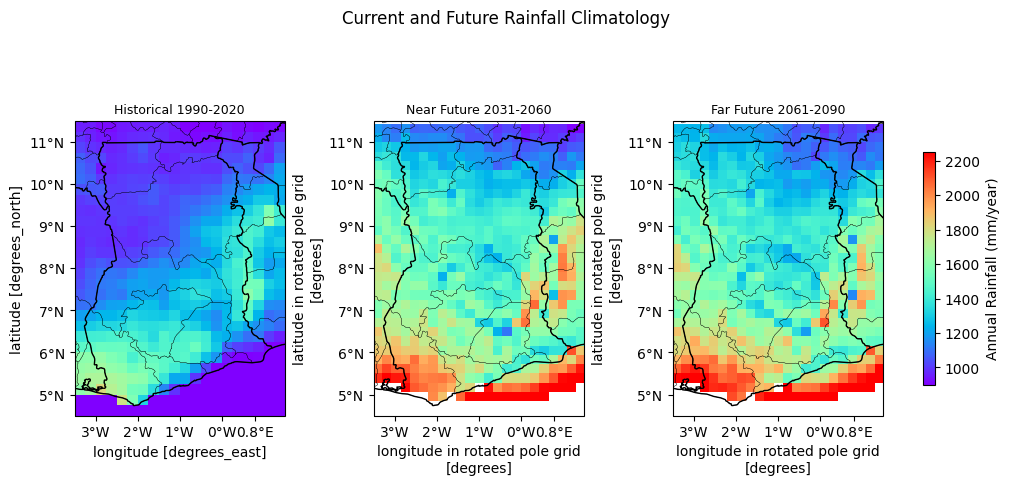

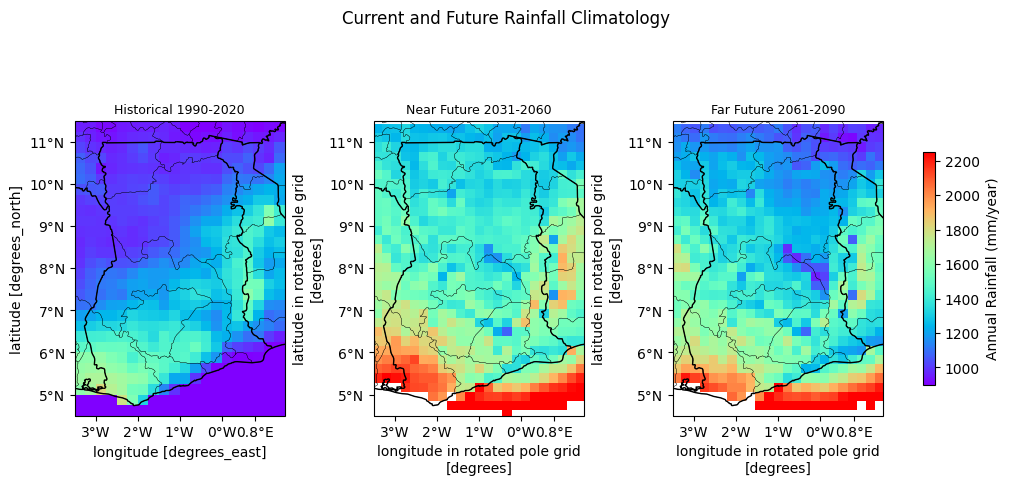

In [14]:
figures(ds_chirps, ds_rcp26)
figures(ds_chirps, ds_rcp85)

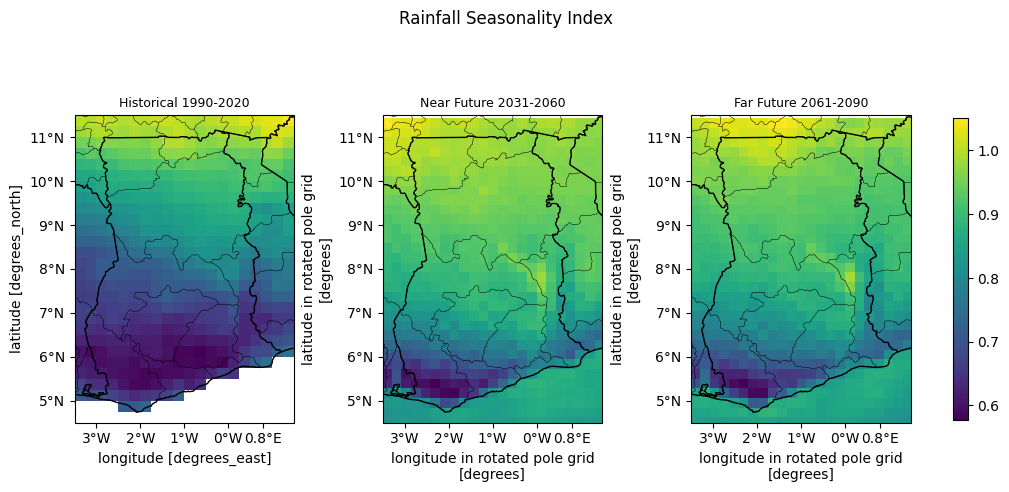

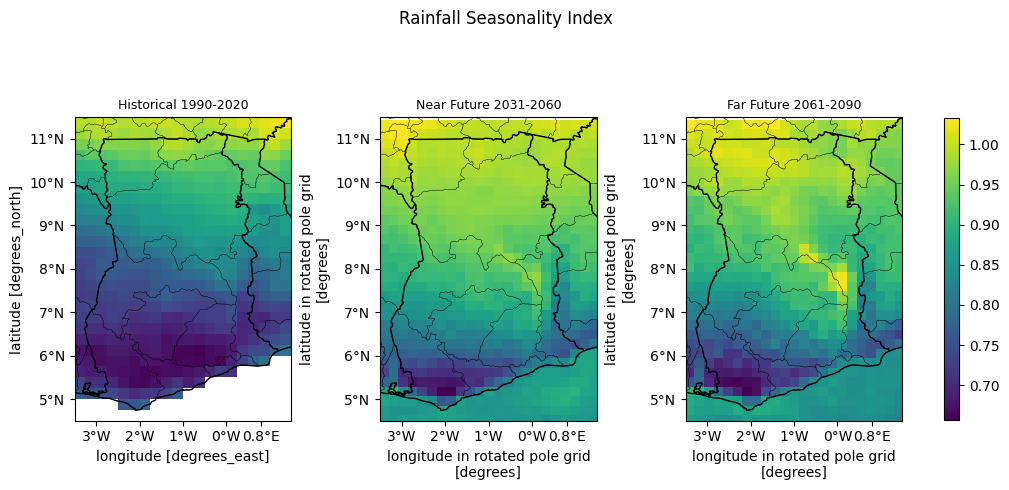

In [15]:
srai_fig(ds_chirps,ds_rcp26)
srai_fig(ds_chirps,ds_rcp85)

| Seasonality Index | Precipitation regime |
| :-: | :- |
| 0.19 | Precipitation spread throughout the year |
| 0.20-0.39 | Precipitation spread throughout the year, but with a definite wetter season |
| 0.40-0.59 | Rather seasonal with a short drier season |
| 0.60-0.79 | Seasonal |
| 0.80-0.99 | Marked seasonal with a long dry season |
| 1.00-1.19 | Most precipitation in <3 months |
| 1.20 | Extreme seasonality, with almost all precipitation in 1-2 months |


<ipython-input-6-8c967501cb31>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()#w_pad=0.5)


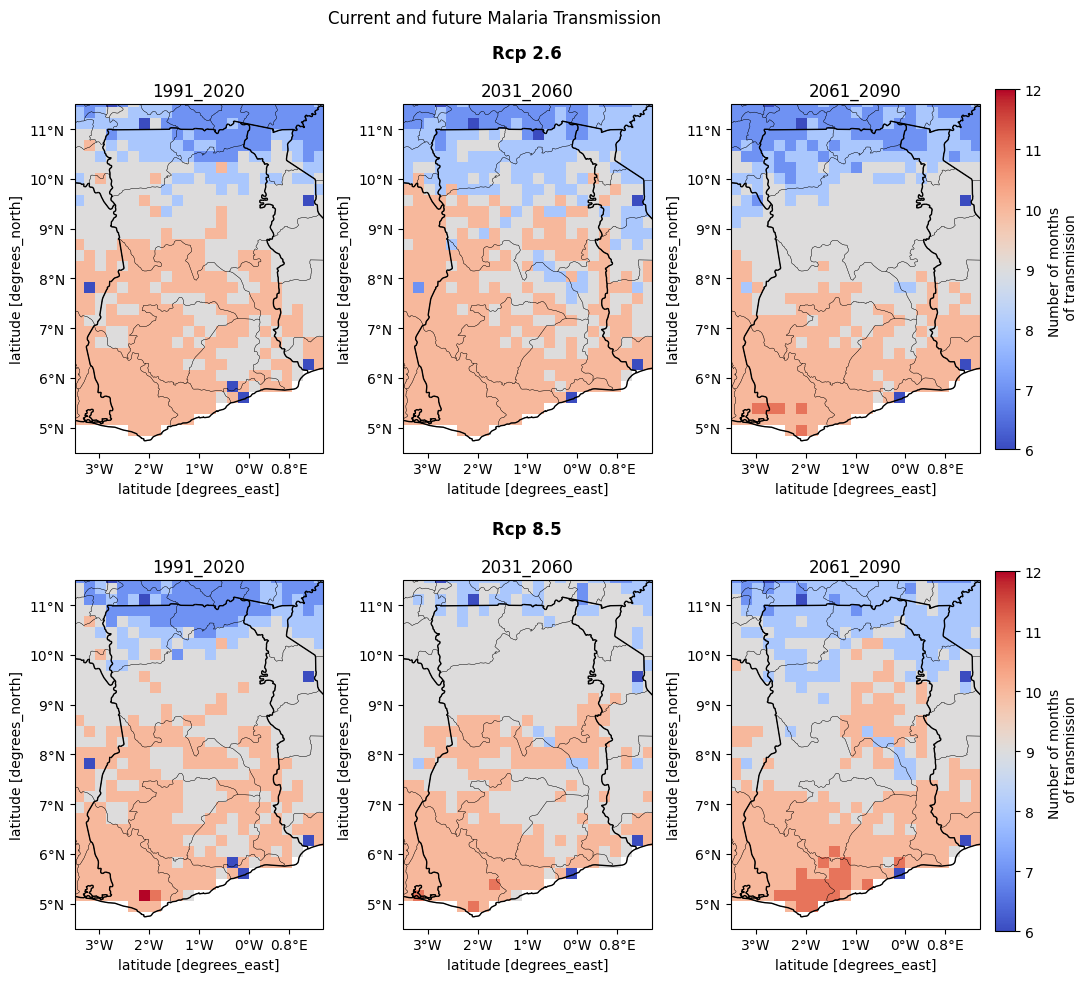

In [11]:
fig_mal(mal_data26,mal_data85)

In [ ]:
mpi

['drive/MyDrive/Colab Notebooks/PROFS-WORK/../../Mpi/RR_Tm_GHA-22_MPI-M-MPI-ESM-LR_historical_rcp26_r1i1p1_GERICS-REMO2015_v1_day_19710101-21001231.nc',
 'drive/MyDrive/Colab Notebooks/PROFS-WORK/../../Mpi/RR_Tm_GHA-22_MPI-M-MPI-ESM-LR_historical_rcp85_r1i1p1_GERICS-REMO2015_v1_day_19710101-21001231.nc']

<ipython-input-5-8c967501cb31>:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5)


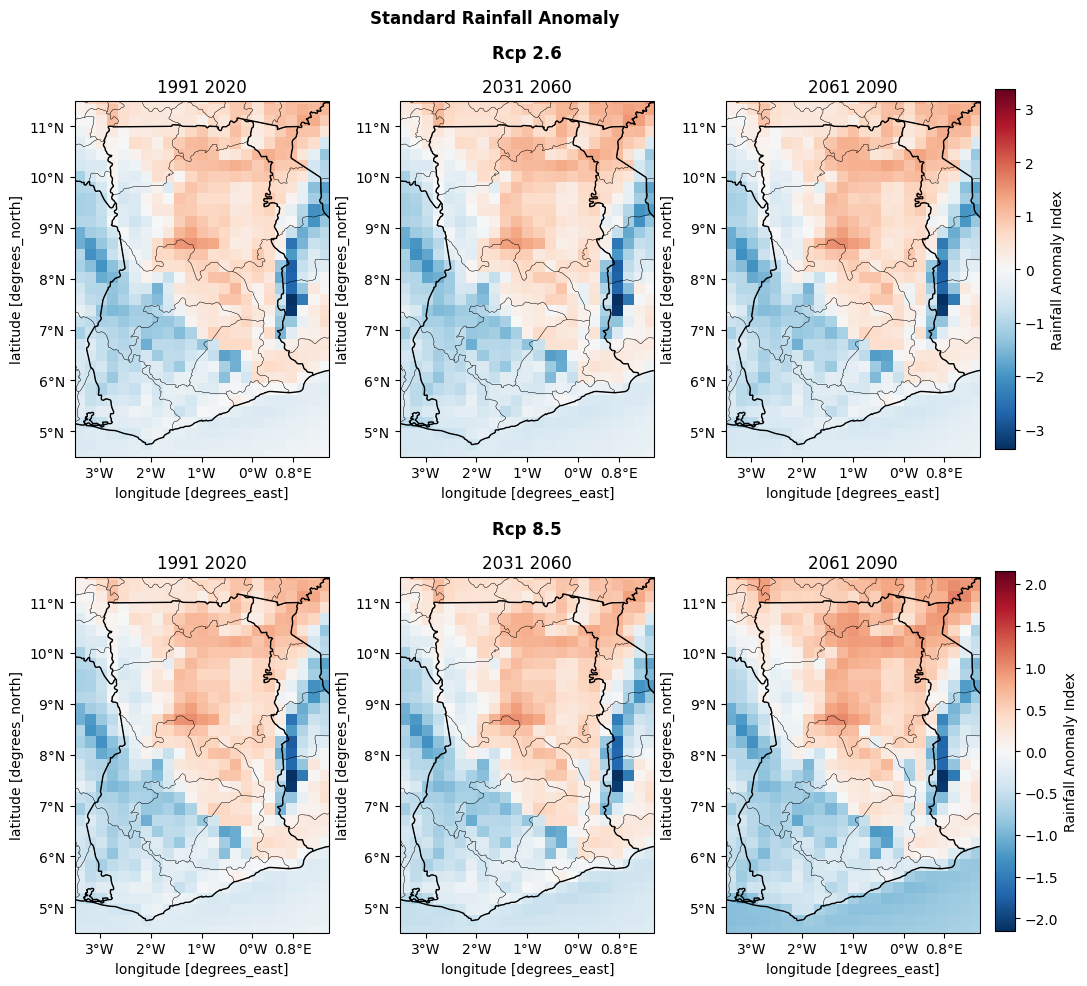

In [6]:
anom_fig_(mpi)